# Predicting House Prices on Kaggle

We will build a real project -- and submit for the first time. **Remember, there is no losing, there is always learning**.

In [1]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## Downloading Data

Throughout the book, we will train and test models
on various downloaded datasets.
Here, we (**implement two utility functions**)
for downloading and extracting zip or tar files.
Again, we skip implementation details of
such utility functions.


In [2]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

## Kaggle


In [3]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

The training dataset includes 1460 examples,
80 features, and one label, while the validation data
contains 1459 examples and 80 features.


In [4]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


## Data Preprocessing

Let's [**take a look at the first four and final two features
as well as the label (SalePrice)**] from the first four examples.


In [5]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


The following code will simply preprocess the data. Nothing more -- this step is usually done after the EDA.

In [6]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))

    ### `features` IS THE FULL DATA ###
    
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True) # automatically perform one-hot on categorical

    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy() # take till train
    self.train[label] = self.raw_train[label] # had to take from the original
    self.val = features[self.raw_train.shape[0]:].copy()

> You can see that this conversion increases
the number of features from 79 to 331 (excluding ID and label columns).


In [7]:
temp = data.preprocess()
data.train.shape

(1460, 331)

## Error Measure

We will use the **Root Mean Squared Log Error**

**Key points:**

1. **Relative vs. Absolute Error:**
   - Relative error, which measures the error **as a proportion** of the true value, is more relevant for house price prediction than absolute error.
   - A small absolute error can be significant for low-priced houses but negligible for high-priced ones.

2. **Logarithmic Transformation:**
   - **Taking the logarithm** of both predicted and actual prices helps mitigate the impact of large differences in absolute values.
   - This transformation focuses on the relative differences, making the model more sensitive to smaller errors in high-priced houses.
   - The root-mean-squared-error (RMSE) calculated on the logarithmic scale is used as the evaluation metric for the competition.

By using logarithmic transformation and the RMSE on the logarithmic scale, the model can be better evaluated and tuned to make more accurate predictions, especially for higher-priced houses.

   $$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}$$


In [8]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    
    label = 'SalePrice' 
    data = self.train if train else self.val 
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float), dtype=torch.float32)
    
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])), # X 
               torch.log(get_tensor(data[label])).reshape((-1, 1))) # Y

    ## The tensorloarder expects the data in X,Y format.
    return self.get_tensorloader(tensors, train)

## $K$-Fold Cross-Validation

**Key points:**

1. **Cross-validation:** It involves splitting the dataset into multiple folds. Each fold is used as a validation set to evaluate the model trained on the remaining folds.
2. **Model Selection and Hyperparameter Tuning:** Cross-validation helps in selecting the best model architecture and tuning its hyperparameters by assessing performance on different subsets of the data.
3. **Implementation:** The passage outlines a simple approach to implement cross-validation, where each fold is created by slicing out a specific segment of the data. While this method is sufficient for small datasets, more efficient techniques exist for larger datasets.


In [10]:
def k_fold_data(data, k):
    ''' This will just create the folds -- it is not an iterator '''

    # to store folds (a combination of train and val)
    rets = []
    
    # size of each fold
    fold_size = data.train.shape[0] // k

    # for j in total folds
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(batch_size=data.batch_size, # this line will create new Kaggle data which is randomized
                                train=data.train.drop(index=idx),
                                val=data.train.loc[idx]))
    return rets

[**The average validation error is returned**]
when we train $K$ times in the $K$-fold cross-validation.


In [25]:
d2l.LinearRegression??

Init signature: d2l.LinearRegression(lr)
Source:        
class LinearRegression(d2l.Module):
    """The linear regression model implemented with high-level APIs.

    Defined in :numref:`sec_linear_concise`"""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

    def forward(self, X):
        """Defined in :numref:`sec_linear_concise`"""
        return self.net(X)

    def loss(self, y_hat, y):
        """Defined in :numref:`sec_linear_concise`"""
        fn = nn.MSELoss()
        return fn(y_hat, y)

    def configure_optimizers(self):
        """Defined in :numref:`sec_linear_concise`"""
        return torch.optim.SGD(self.parameters(), self.lr)

    def get_w_b(self):
        """Defined in :numref:`sec_linear_concise`"""
        return (self.net.weight.data, self.net.bias.data)
File:           c:\users\aayus\anaconda3\envs\d2

In [14]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

## [**Model Selection**]

In this example, we pick an untuned set of hyperparameters
and leave it up to the reader to improve the model.
Finding a good choice can take time,
depending on how many variables one optimizes over.
With a large enough dataset,
and the normal sorts of hyperparameters,
$K$-fold cross-validation tends to be
reasonably resilient against multiple testing.
However, if we try an unreasonably large number of options
we might find that our validation
performance is no longer representative of the true error.


C:\Users\aayus\anaconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\aayus\anaconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\aayus\anaconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\aayus\anaconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under h

average validation log mse = 0.17881923288106918


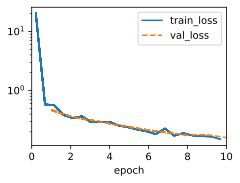

In [15]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

In [ ]:
# 

Notice that sometimes the number of training errors
for a set of hyperparameters can be very low,
even as the number of errors on $K$-fold cross-validation
grows considerably higher.
This indicates that we are overfitting.
Throughout training you will want to monitor both numbers.
Less overfitting might indicate that our data can support a more powerful model.
Massive overfitting might suggest that we can gain
by incorporating regularization techniques.

##  [**Submitting Predictions on Kaggle**]

Now that we know what a good choice of hyperparameters should be,
we might 
calculate the average predictions 
on the test set
by all the $K$ models.
Saving the predictions in a csv file
will simplify uploading the results to Kaggle.
The following code will generate a file called `submission.csv`.


In [16]:
models

[LinearRegression(
   (net): Linear(in_features=330, out_features=1, bias=True)
 ),
 LinearRegression(
   (net): Linear(in_features=330, out_features=1, bias=True)
 ),
 LinearRegression(
   (net): Linear(in_features=330, out_features=1, bias=True)
 ),
 LinearRegression(
   (net): Linear(in_features=330, out_features=1, bias=True)
 ),
 LinearRegression(
   (net): Linear(in_features=330, out_features=1, bias=True)
 )]

In [38]:
# this will store prediction on the validation data
preds = []
for model in models: # pick each model
    pred = model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
    preds.append(pred)

# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)

# Using Neural Net -- Improving Accuracy

In [44]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.LazyLinear(512), nn.ReLU(),
                                 nn.Dropout(0.2), nn.LazyLinear(512), nn.ReLU(),
                                 nn.Dropout(0.2), nn.LazyLinear(256), nn.ReLU(),
                                 nn.Dropout(0.2), nn.LazyLinear(128), nn.ReLU(),
                                 nn.Dropout(0.2), nn.LazyLinear(64), nn.ReLU(),
                                 nn.Dropout(0.2), nn.LazyLinear(1))

    def forward(self, X):
        return self.net(X) 

    def loss(self, y_hat, y):
        """Defined in :numref:`sec_linear_concise`"""
        fn = nn.MSELoss()
        return fn(y_hat, y)

    def configure_optimizers(self):
        """Defined in :numref:`sec_linear_concise`"""
        return torch.optim.SGD(self.parameters(), self.lr)

In [45]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = LinearRegression(lr=lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

C:\Users\aayus\anaconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\aayus\anaconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


average validation log mse = 0.15405737391362587


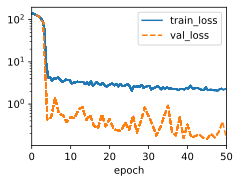

In [46]:
trainer = d2l.Trainer(max_epochs=50)
models = k_fold(trainer, data, k=3, lr=0.001)

In [47]:
# this will store prediction on the validation data
preds = []
for model in models: # pick each model
    pred = model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
    preds.append(pred)

# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)

# Meh!

Next, as demonstrated in :numref:`fig_kaggle_submit2`,
we can submit our predictions on Kaggle
and see how they compare with the actual house prices (labels)
on the test set.
The steps are quite simple:

* Log in to the Kaggle website and visit the house price prediction competition page.
* Click the “Submit Predictions” or “Late Submission” button.
* Click the “Upload Submission File” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.
* Click the “Make Submission” button at the bottom of the page to view your results.

![Submitting data to Kaggle](../img/kaggle-submit2.png)
:width:`400px`
:label:`fig_kaggle_submit2`

## Summary and Discussion

Real data often contains a mix of different data types and needs to be preprocessed.
Rescaling real-valued data to zero mean and unit variance is a good default. So is replacing missing values with their mean.
Furthermore, transforming categorical features into indicator features allows us to treat them like one-hot vectors.
When we tend to care more about
the relative error than about the absolute error,
we can 
measure the discrepancy in the logarithm of the prediction.
To select the model and adjust the hyperparameters,
we can use $K$-fold cross-validation .



## Exercises

1. Submit your predictions for this section to Kaggle. How good are they?
1. Is it always a good idea to replace missing values by a mean? Hint: can you construct a situation where the values are not missing at random?
1. Improve the score by tuning the hyperparameters through $K$-fold cross-validation.
1. Improve the score by improving the model (e.g., layers, weight decay, and dropout).
1. What happens if we do not standardize the continuous numerical features as we have done in this section?


[Discussions](https://discuss.d2l.ai/t/107)
